# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Jacopo De Stefani - __[Jacopo.De.Stefani@ulb.ac.be](mailto:Jacopo.De.Stefani@ulb.ac.be)__
### Théo Verhelst - __[Theo.Verhelst@ulb.ac.be](mailto:Theo.Verhelst@ulb.ac.be)__
### Gianluca Bontempi - __[gbonte@ulb.ac.be](mailto:gbonte@ulb.ac.be)__

## TP 5 - Ensembles of models and feature selection

####  April 20, 2021

#### Materials originally developed by *Yann-Aël Le Borgne, Fabrizio Carcillo and Gianluca Bontempi*

## Overview

Feature selection and ensembles of models are two techniques which can be used to improve the accuracy of preditions. 

Feature selection aims at reducing the dimensionality of the problem, and is useful when input variables contain redundant or irrelevant (noisy) information. Benefits are twofold: it decreases the training time by simplifying the problem, and it decreases the complexity of the predictive model. This in turn usually improves the prediction accuracy, since high-dimensionality makes predictive models more prone to overfitting, and estimates of parameters more variant. 

There are three main approaches to feature selection:
- **Filter methods:** 
These methods relies solely on the data and their intrinsic properties, without considering the impact of the selected features on the learning algorithm performance. For this reason, they are often used as preprocessing techniques.
- **Wrapper methods:** 
These methods assess subsets of variables according to their usefulness to a given predictor. The feature selection is perfomed using an evaluation function that includes the predictive performance of the consider learning algorithm as a selection criterion. 
- **Embedded methods:** 
These methods are specific to given learning machines, and usually built-in in the learning procedure (e.g. random forest, regularization based techniques).

Ensembles of models consist in building several predictive models using resampled subsets of the original training set. The method works particularly well for predictive models with high variance (for example, decision trees or neural networks). The average prediction of the resulting models usually strongly decreases the variance component of the error, and as a consequence improves the prediction accuracy. 

In this session, we will illustrate both techniques using the IMDB 5000 dataset, which contains 27 variables describing 5043 movies. The variables contain information about the director, actors, number of Facebook likes for each actor, duration, genre, language, country, etc... We will use them to predict the movie success (through the IMDB score). The dataset together with a description of the variables is at https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset.

The dataset is on the github of the course, in `5_EnsemblesFeatureSelection/movie_metadata.csv`

## Preliminaries

### Supervised learning

The process of supervised learning involves the presence of an entity (the learner, also called prediction model), whose goal is to learn the mapping between inputs and outputs in a given problem.

A supervised learning problem can formulated as follows:

\begin{equation*}
 y = m(\mathbf{x})  
\end{equation*}

where:
- $y$ represents the output variable (also called target)
- $\mathbf{x}$ represents the vector of inputs (also called features).
- $m$ is the (unknown) mapping between input and outputs.

In the majority of the supervised learning problems, the mapping $m$ between input and outputs is unknown and needs to be estimated on basis of the available input/output observation pairs $(\mathbf{x}_i,y_i)$.

## Classification vs regression

Both classification and regression are sub-fields of *supervised learning*. In the two cases, we have predictive variables $\mathbf{x}$ and a target variable $y$. 
The main difference betweet the two type of problems is the type of the target variabile:

- In classification, $y$ is a discrete variable; i.e $y \in \{C_1,\cdots,C_k\}$
- In regression, $y$ is a continuous variable; i.e $y \in \mathbb{R}$

In this practical, unlike the previous ones, we will tackle our problem as a regression problem, with the IMDB score being the continuous target variable to predict.


## Data overview and preprocessing

Let us load and select a random subset of 1000 movies

In [7]:
data<-read.csv("movie_metadata.csv",stringsAsFactors = T)
set.seed(2)
data<-data[sample(nrow(data),1000),]

### Dataset overview

In [8]:
dim(data)


[1] 1000   28

In [9]:
options(repr.matrix.max.cols=50)
data[1:2,]

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
,<fct>,<fct>,<int>,<int>,<int>,<int>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>
3925,Color,Oliver Stone,40,110,0,237,Zach Grenier,721,3468572,Drama,Michael Wincott,Talk RadioÂ,10073,1966,Bill Johnson,0,listener|neo nazi|radio|radio station|radio talk show,http://www.imdb.com/title/tt0096219/?ref_=fn_tt_tt_1,78,English,USA,R,4e+06,1988,246,7.3,1.85,816
4806,Color,Paul Fox,80,80,3,39,Jeff Seymour,108,NA,Horror|Thriller,Dov Tiefenbach,The Dark HoursÂ,4788,272,Gordon Currie,0,brain tumor|champagne|game|psychiatrist|weekend,http://www.imdb.com/title/tt0402249/?ref_=fn_tt_tt_1,52,English,Canada,R,5e+05,2005,64,6.1,1.85,166


In [ ]:
summary(data)

We see there is a mix of categorical and numerical variables, and some missing values. In order to simplify the analysis, let us remove the categorical variables, and replace the NA values with the mean values of the variables.

### Remove categorical variables

Check the type of input variables

In [10]:
sapply(data[1,],class)

color             director_name    num_critic_for_reviews 
                 "factor"                  "factor"                 "integer" 
                 duration   director_facebook_likes    actor_3_facebook_likes 
                "integer"                 "integer"                 "integer" 
             actor_2_name    actor_1_facebook_likes                     gross 
                 "factor"                 "integer"                 "integer" 
                   genres              actor_1_name               movie_title 
                 "factor"                  "factor"                  "factor" 
          num_voted_users cast_total_facebook_likes              actor_3_name 
                "integer"                 "integer"                  "factor" 
     facenumber_in_poster             plot_keywords           movie_imdb_link 
                "integer"                  "factor"                  "factor" 
     num_user_for_reviews                  language                   country 
                "integer"                  "factor"                  "factor" 
           content_rating                    budget                title_year 
                 "factor"                 "numeric"                 "integer" 
   actor_2_facebook_likes                imdb_score              aspect_ratio 
                "integer"                 "numeric"                 "numeric" 
     movie_facebook_likes 
                "integer"

Get indices of categorical (factor) variables

In [11]:
factor_variables<-which(sapply(data[1,],class)=="factor")
factor_variables

color   director_name    actor_2_name          genres    actor_1_name 
              1               2               7              10              11 
    movie_title    actor_3_name   plot_keywords movie_imdb_link        language 
             12              15              17              18              20 
        country  content_rating 
             21              22

Remove categorical variables

In [12]:
data_preprocessed<-data[,-factor_variables]
summary(data_preprocessed)

 num_critic_for_reviews    duration   director_facebook_likes
 Min.   :  1.0          Min.   :  7   Min.   :    0.00       
 1st Qu.: 48.0          1st Qu.: 93   1st Qu.:    6.75       
 Median :103.0          Median :103   Median :   44.00       
 Mean   :135.1          Mean   :106   Mean   :  669.26       
 3rd Qu.:184.2          3rd Qu.:116   3rd Qu.:  204.75       
 Max.   :765.0          Max.   :511   Max.   :21000.00       
 NA's   :16             NA's   :4     NA's   :24             
 actor_3_facebook_likes actor_1_facebook_likes     gross          
 Min.   :    0.0        Min.   :    0          Min.   :      703  
 1st Qu.:  120.0        1st Qu.:  623          1st Qu.:  5003486  
 Median :  395.0        Median :  979          Median : 25025352  
 Mean   :  602.2        Mean   : 5951          Mean   : 46927291  
 3rd Qu.:  642.0        3rd Qu.:11000          3rd Qu.: 60549232  
 Max.   :19000.0        Max.   :49000          Max.   :658672302  
 NA's   :5              NA's   :3  

### Replace NA values with mean values

In [13]:
replace_na_with_mean_value<-function(vec) {
    mean_vec<-mean(vec,na.rm=T)
    vec[is.na(vec)]<-mean_vec
    vec
}

In [14]:
data_preprocessed<-data.frame(apply(data_preprocessed,2,replace_na_with_mean_value))
summary(data_preprocessed)

 num_critic_for_reviews    duration   director_facebook_likes
 Min.   :  1.0          Min.   :  7   Min.   :    0.0        
 1st Qu.: 48.0          1st Qu.: 93   1st Qu.:    7.0        
 Median :105.5          Median :103   Median :   48.5        
 Mean   :135.1          Mean   :106   Mean   :  669.3        
 3rd Qu.:181.0          3rd Qu.:116   3rd Qu.:  234.0        
 Max.   :765.0          Max.   :511   Max.   :21000.0        
 actor_3_facebook_likes actor_1_facebook_likes     gross          
 Min.   :    0.0        Min.   :    0.0        Min.   :      703  
 1st Qu.:  120.0        1st Qu.:  623.8        1st Qu.:  9158619  
 Median :  397.5        Median :  982.0        Median : 38108330  
 Mean   :  602.2        Mean   : 5950.9        Mean   : 46927291  
 3rd Qu.:  642.0        3rd Qu.:11000.0        3rd Qu.: 47159944  
 Max.   :19000.0        Max.   :49000.0        Max.   :658672302  
 num_voted_users  cast_total_facebook_likes facenumber_in_poster
 Min.   :     5   Min.   :    0 

### Input and output variables

The output variable (Y) is the `imdb_score`, and all other variables (X) are considered as inputs.

In [15]:
set.seed(3)

X<-data_preprocessed[,setdiff(colnames(data_preprocessed),"imdb_score")]
Y<-data_preprocessed[,"imdb_score"]

N<-nrow(X)    #Number of examples
n<-ncol(X)    #Number of input variables


Distribution of the `imdb_score`

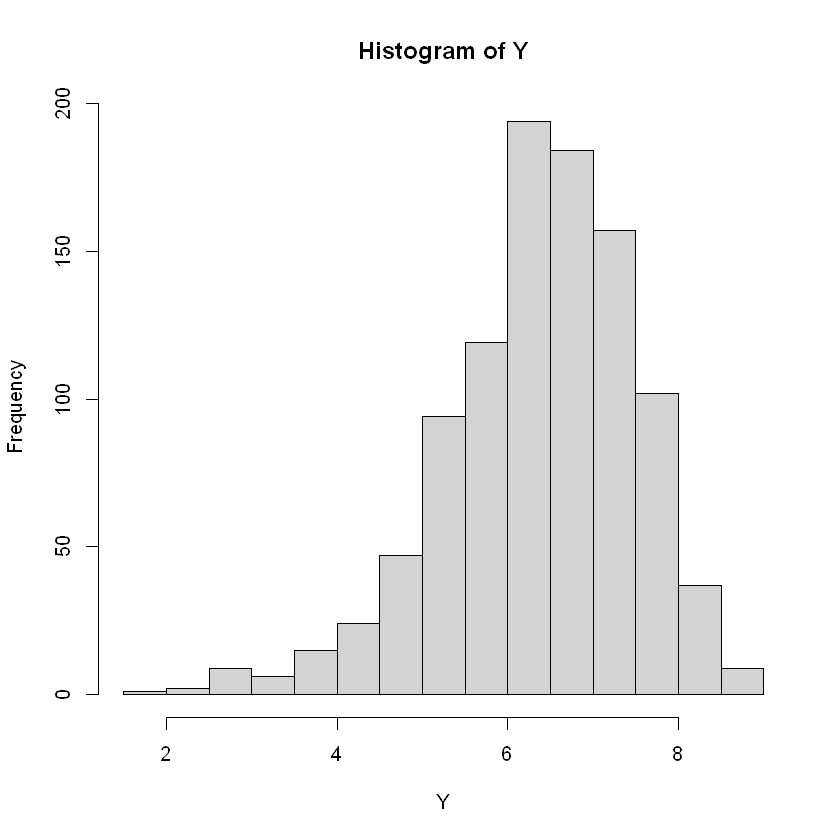

In [16]:
hist(Y)

In [17]:
mean(Y)

[1] 6.4255

In [18]:
var(Y)

[1] 1.246947

### 1) Modelling with linear and decision tree models

#### Linear model

* Let us create a linear model for predicting the IMDB score on the basis of the other variables, and compute its empricial mean square error

In [ ]:
DS<-cbind(X,imdb_score=Y)
    
model<- ### Fill with your code here
        
Y.hat<- predict(model,X)
        
empirical_error<- ### Fill with your code here

print(paste("Empirical error=",round(empirical_error,digits=4)))



* Which input variables are statistically correlated with the output?

In [ ]:
summary(model)

* Compute the validation error with a 10-fold cross-validation

In [ ]:
size.CV<-floor(N/10)

CV.err<-numeric(10)

for (i in 1:10) {
     i.ts<-  ### Complete the code. i.ts should be the indices of the test for the i-th fold
     X.ts<-X[i.ts,]  
     Y.ts<-Y[i.ts]  
     
     i.tr<-  ### Complete the code. i.tr should be the indices of the training sefor the i-th fold
     X.tr<-X[i.tr,]
     Y.tr<-Y[i.tr]                          
     
     DS<-cbind(X.tr,imdb_score=Y.tr)
    
     model<- lm(imdb_score~.,DS)
        
     Y.hat.ts<- predict(model,X.ts)
        
     CV.err[i]<-mean((Y.hat.ts-Y.ts)^2)
}
    

print(paste("CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))



#### Decision tree

* Modify the previous code to compute the empirical error using a decision tree model. Use the rpart package (see `?rpart` for help)

In [ ]:
library(rpart)       ### Run install.packages("rpart") to install

In [ ]:
DS<-cbind(X,imdb_score=Y)

model<- ### Fill with you code here
        
Y.hat<- predict(model,X)
        
empirical_error<-mean((Y.hat-Y)^2) 

print(paste("Empirical error=",round(empirical_error,digits=4)))



* Plot the resulting tree using the `prp` function from the library `rpart.plot`

In [ ]:
library(rpart.plot)  ### Run install.packages("rpart.plot") to install

In [ ]:
prp(model)

* What is the 10-fold cross-validation error using a decision tree model?

In [ ]:
size.CV<-floor(N/10)

CV.err<-numeric(10)

for (i in 1:10) {
     i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
     X.ts<-X[i.ts,]  
     Y.ts<-Y[i.ts]  
     
     i.tr<-setdiff(1:N,i.ts)                
     X.tr<-X[i.tr,]
     Y.tr<-Y[i.tr]                          
     
     DS<-cbind(X.tr,imdb_score=Y.tr)
    
     model<- rpart(imdb_score~.,DS)
        
     Y.hat.ts<- predict(model,X.ts)
        
     CV.err[i]<-mean((Y.hat.ts-Y.ts)^2)
    }
    

print(paste("CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))



## 2) Ensemble of models

Let us now create an ensemble of $R$ linear models to make predictions. Complete the code below so that:

* The training set is resampled before building a model
* The predictions of all model are averaged before testing

In [ ]:
size.CV<-floor(N/10)
R<-20

CV.err<-numeric(10)

for (i in 1:10) {
     i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
     X.ts<-X[i.ts,]  
     Y.ts<-Y[i.ts]  
     
     
     i.tr<-setdiff(1:N,i.ts)                
    
     Y.hat.ts.R<-matrix(0,nrow=nrow(X.ts),ncol=R)
    
     for (r in 1:R) {
         i.tr.resample<-    ### Complete code: Resample training set with replacement
         X.tr<-X[i.tr.resample,]
         Y.tr<-Y[i.tr.resample]                          
     
         DS<-cbind(X.tr,imdb_score=Y.tr)
    
         model<- lm(imdb_score~.,DS)
        
         Y.hat.ts.R[,r]<- predict(model,X.ts)
     
     }
    
     Y.hat.ts<-apply(Y.hat.ts.R,1,mean)
     CV.err[i]<-mean((Y.hat.ts-Y.ts)^2)
     }

print(paste("CV error=",round(mean(CV.err),digits=4), " ; std dev=",round(sd(CV.err),digits=4)))


* Is the CV error lower than with a single linear model?
* Use a decision tree as the base model. Is the CV error lower?

## 3) Feature selection

Two are the main approaches to feature selection:


* **Filter methods:** they are preprocessing methods. They attempt to
assess the merits of features from the data, ignoring the effects of
the selected feature subset on the performance of the learning
algorithm. Examples are methods that select variables by ranking them
through compression techniques (like PCA), or by computing correlation or a more advanced similarity measure such as minimum redundancy maximum relevance (mRMR) with the output.

*  **Wrapper methods:** these methods assess subsets of variables
according to their usefulness to a given predictor. The method
conducts a search for a good subset using the learning algorithm
itself as part of the evaluation function. The problem boils 
down to a problem of stochastic state space search. Example
are the stepwise methods proposed in linear regression analysis.



### Filter methods

#### Correlation with the output

* The following code performs features selection by keeping the most correlated variables with the output. Compare the results for linear models and decision trees. What are the smallest CV errors, and how many features were needed?


In [ ]:
size.CV<-floor(N/10)

CV.err<-matrix(0,nrow=n,ncol=10)

for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
     
    i.tr<-setdiff(1:N,i.ts)
    X.tr<-X[i.tr,]
    Y.tr<-Y[i.tr]
     
    correlation<-abs(cor(X.tr,Y.tr))
    ranking<-sort(correlation,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        DS<-cbind(X.tr[,ranking[1:nb_features],drop=F],imdb_score=Y.tr)
        model<- lm(imdb_score~.,DS)
        
        Y.hat.ts<- predict(model,X.ts[,ranking[1:nb_features],drop=F])
        
        CV.err[nb_features,i]<-mean((Y.hat.ts-Y.ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV.err,1,mean),digits=4), " ; std dev=",round(apply(CV.err,1,sd),digits=4)))



#### mRMR

* The following code performs features selection by using the mRMR approach (see Section 12.8 - Syllabus). Compare the results for linear models and decision trees. What are the smallest CV errors, and how many features were needed?

In [ ]:
size.CV<-floor(N/10)

CV.err<-matrix(0,nrow=n,ncol=10)

for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X[i.ts,]  
    Y.ts<-Y[i.ts]  
     
    i.tr<-setdiff(1:N,i.ts)
    X.tr<-X[i.tr,]
    Y.tr<-Y[i.tr]
    
    
    correlation<-abs(cor(X.tr,Y.tr))
    
    selected<-c()
    candidates<-1:n
    
    #mRMR ranks the variables by taking account not only the correlation with the output, but also by avoiding redudant variables
    for (j in 1:n) {
        redudancy.score<-numeric(length(candidates))
        if (length(selected)>0) {
            cor.selected.candidates<-cor(X.tr[,selected,drop=F],X.tr[,candidates,drop=F])
            redudancy.score<-apply(cor.selected.candidates,2,mean)
        }
        
        mRMR.score<-correlation[candidates]-redudancy.score
        
        selected_current<-candidates[which.max(mRMR.score)]
        selected<-c(selected,selected_current)
        candidates<-setdiff(candidates,selected_current)
    }
    
    ranking<-selected
     
    for (nb_features in 1:n) {
        DS<-cbind(X.tr[,ranking[1:nb_features],drop=F],imdb_score=Y.tr)
        model<- lm(imdb_score~.,DS)
        
        Y.hat.ts<- predict(model,X.ts[,ranking[1:nb_features],drop=F])
        
        CV.err[nb_features,i]<-mean((Y.hat.ts-Y.ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV.err,1,mean),digits=4), " ; std dev=",round(apply(CV.err,1,sd),digits=4)))


#### PCA

* The following code performs features selection by first transforming the inputs using PCA, and then keeping the most relevant principal components in the model. Compare the results for linear models and decision trees. What are the smallest CV errors, and how many features were needed?



In [ ]:
size.CV<-floor(N/10)

CV.err<-matrix(0,nrow=n,ncol=10)

X_pca<-data.frame(prcomp(X,retx=T)$x)

for (i in 1:10) {
    i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
    X.ts<-X_pca[i.ts,]  
    Y.ts<-Y[i.ts]  
     
    i.tr<-setdiff(1:N,i.ts)
    X.tr<-X_pca[i.tr,]
    Y.tr<-Y[i.tr]
     
    for (nb_features in 1:n) {
        DS<-cbind(X.tr[,1:nb_features,drop=F],imdb_score=Y.tr)
        model<- lm(imdb_score~.,DS)
        
        Y.hat.ts<- predict(model,X.ts[,1:nb_features,drop=F])
        
        CV.err[nb_features,i]<-mean((Y.hat.ts-Y.ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV.err,1,mean),digits=4), " ; std dev=",round(apply(CV.err,1,sd),digits=4)))


### Wrapper method: Forward selection

* The following code performs features selection by using a forward selection method (Section 12.4 - Syllabus). Compare the results for linear models and decision trees. What are the smallest CV errors, and how many features were needed?


In [ ]:
size.CV<-floor(N/10)

selected<-NULL

for (round in 1:n) { 
    candidates<-setdiff(1:n,selected)
    
    CV.err<-matrix(0,nrow=length(candidates),ncol=10)
    
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        for (i in 1:10) {
            i.ts<-(((i-1)*size.CV+1):(i*size.CV))  
            X.ts<-X[i.ts,features_to_include,drop=F]  
            Y.ts<-Y[i.ts]  
     
            i.tr<-setdiff(1:N,i.ts)
            X.tr<-X[i.tr,features_to_include,drop=F]
            Y.tr<-Y[i.tr]
     
            DS<-cbind(X.tr,imdb_score=Y.tr)
            model<- lm(imdb_score~.,DS)
        
            Y.hat.ts<- predict(model,X.ts)
        
            CV.err[j,i]<-mean((Y.hat.ts-Y.ts)^2)
        }
    }
    CV.err.mean<-apply(CV.err,1,mean)
    CV.err.sd<-apply(CV.err,1,sd)
    selected_current<-which.min(CV.err.mean)              
    selected<-c(selected,candidates[selected_current])
    print(paste("Round ",round," ; Selected feature: ",candidates[selected_current]," ; CV error=",round(CV.err.mean[selected_current],digits=4), " ; std dev=",round(CV.err.sd[selected_current],digits=4)))

}
                   


## Further preprocessing to add categorical variables

Categorical variables usually need to be transformed with 'one-hot-encoding' in order to be processed by a learning algorithm. That is, for each value of the categorical variable, a binary feature is created, which is set to one whenever that value is present. This can be done using the `dummy.data.frame` of the `dummies` package.

```
install.packages('dummies')
library(dummies)
```

In the following, we add some categorical variables to the peprocessing dataset. The set of categorical variables is

In [ ]:
factor_variables

Let us have an overview of the their content

In [ ]:
data_factor<-data[,factor_variables]

In [ ]:
dim(data_factor)

In [ ]:
data_factor[1:2,]

Let us keep four of them: Color, language, country and content_rating, and transform them with one-hot-encoding

In [ ]:
variable_to_keep<-c("color","language","country","content_rating")

In [ ]:
data_factor_onehot <- dummy.data.frame(data_factor[,variable_to_keep], sep="_")

In [ ]:
dim(data_factor_onehot)

In [ ]:
data_factor_onehot[1:2,]

These could be added to the previously preprocessed dataset, and used to further improve the prediction accuracy using the feature selection/ensemble techniques seen above. 

In [ ]:
data_preprocessed_extended<-cbind(data_preprocessed,data_factor_onehot)

In [ ]:
dim(data_preprocessed_extended)

In [ ]:
summary(data_preprocessed_extended)

## Using other predictive models

Other models could be used, for example support vector machines, neural networks, K-nearest neighbors (using the `svm`, `nnt`or `lazy` functions from the `e1071`, `nnet` or `lazy` packages, respectively). Note that scaling the data is usually necessary when using neural networks and K-nearest neighbors approaches. 
Is the usage of different models improving the predictive performance?